In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

In [2]:
df = pd.read_csv('fer2013.csv')

In [3]:
df.head()

emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
df.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [6]:
df.rename(columns = {' Usage':'Usage',' pixels':'pixels'},inplace=True)

In [7]:
#Assigning Names to Emotions in labels

num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [8]:
k = np.array(list(map(int,df.iloc[0,2].split(" "))),dtype='uint8').reshape((48,48))

In [9]:
k.shape

(48, 48)

In [10]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [11]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

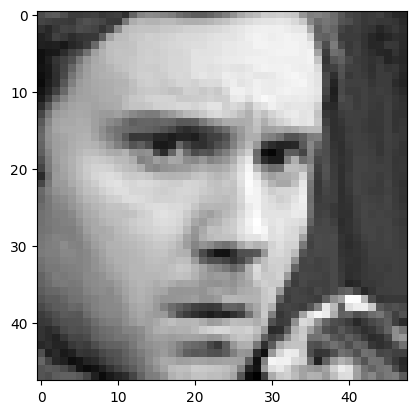

In [12]:
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')

In [13]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [14]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [15]:
X_train.shape

(28709, 48, 48, 1)

In [16]:
import keras
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [17]:
y_train.shape

(28709, 7)

### some image augumentation

In [18]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

In [19]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

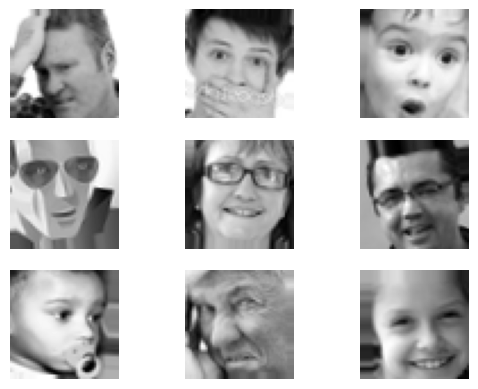

In [20]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

#### Creating model for training 

In [1]:
from keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Sequential

In [2]:
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

     #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [4]:
model = FER_Model()

model.compile(loss='categorical_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)        0     

In [7]:
from tensorflow.keras.utils import plot_model

# Save an image of the model's architecture to a file
plot_model(model, to_file='Vid_CNN.jpg', show_shapes=True, show_layer_names=True,dpi=800, expand_nested=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.781301 to fit



In [30]:
from keras.callbacks import ModelCheckpoint
filepath="static/weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [31]:
num_epochs = 100  
history = model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=test_flow,  
                    validation_steps=len(X_test) / batch_size)

Epoch 1/100
448/448 [==============================] - 43s 53ms/step - loss: 2.6396 - accuracy: 0.2177 - val_loss: 1.8129 - val_accuracy: 0.2536

Epoch 00001: val_loss improved from inf to 1.81290, saving model to static\weights_min_loss.hdf5
Epoch 2/100
448/448 [==============================] - 22s 48ms/step - loss: 1.6863 - accuracy: 0.3189 - val_loss: 1.6206 - val_accuracy: 0.3856

Epoch 00002: val_loss improved from 1.81290 to 1.62060, saving model to static\weights_min_loss.hdf5
Epoch 3/100
448/448 [==============================] - 22s 49ms/step - loss: 1.4783 - accuracy: 0.4261 - val_loss: 1.3902 - val_accuracy: 0.4720

Epoch 00003: val_loss improved from 1.62060 to 1.39018, saving model to static\weights_min_loss.hdf5
Epoch 4/100
448/448 [==============================] - 22s 49ms/step - loss: 1.3759 - accuracy: 0.4762 - val_loss: 1.3042 - val_accuracy: 0.5032

Epoch 00004: val_loss improved from 1.39018 to 1.30424, saving model to static\weights_min_loss.hdf5
Epoch 5/100
448/

### for testing

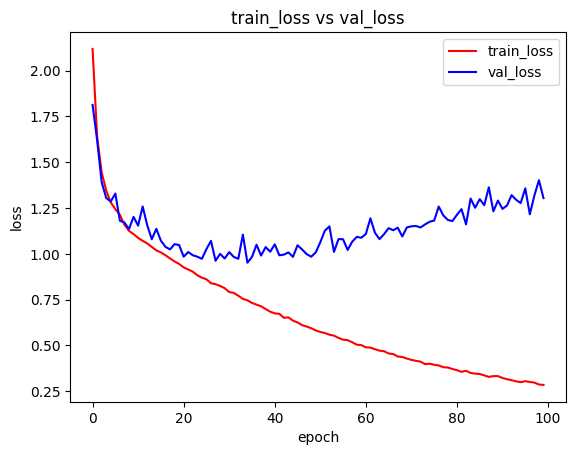

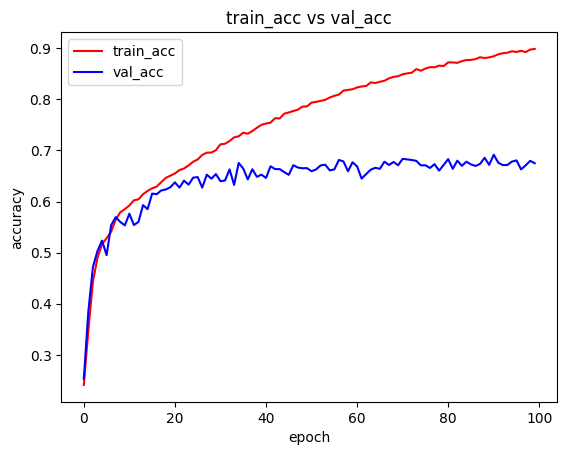

In [32]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))
plt.figure()
plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('staticloss.png')

plt.figure()
plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('static/acc.png')

In [33]:
model.save('static/FER2013.h5')

In [34]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 9ms/step - loss: 1.3041 - accuracy: 0.6748
Test Loss 1.3041152954101562
Test Acc: 0.6748397946357727


113/113 [==============================] - 1s 11ms/step


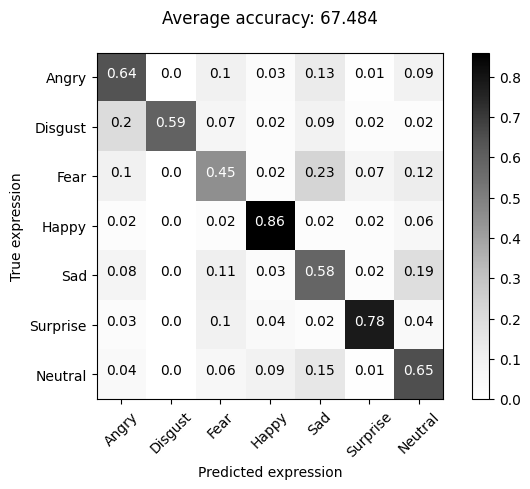

In [44]:
from itertools import product
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.savefig('static/conf.png')
    plt.show()
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(round(np.sum(y_pred == t_te)/len(t_te),5)*100) + '\n')

In [45]:
model_json = model.to_json()
with open("static/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("static/model.h5")
print("Saved model to disk")

Saved model to disk
